<a href="https://colab.research.google.com/github/srfinley/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

#Project work

In [0]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/voterhistorywrangled.csv')

df.head()

,Unnamed: 0,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,district
0,0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,M,11700154.0,NORTH PLAINFIELD,1.0
1,2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,M,11700160.0,NORTH PLAINFIELD,8.0
2,7,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,M,11700157.0,NORTH PLAINFIELD,4.0
3,8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,M,11700151.0,NORTH PLAINFIELD,2.0
4,13,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,M,11700158.0,NORTH PLAINFIELD,5.0


In [4]:
#one is an old index, ballot is future leak
df = df.drop(columns=['Unnamed: 0','ballot'])

df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0


In [14]:
df['sex'].value_counts(dropna=False)
#N here is probably "not recorded" or something similar
#I think sex could be a valuable feature, 
#but I don't want to end up predicting things based on having an N

N    10027
F     6226
M     5437
Name: sex, dtype: int64

In [5]:
#so I'm going to make binary columns for "is male" and "is female"

df['male'] = (df['sex'] == 'M')

df['female'] = (df['sex'] == 'F')

df.head()
#works as intended

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0,False,True
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0,False,False
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0,False,True
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0,False,False


In [0]:
#let's put the sexes in the same model from yesterday!

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier


In [23]:
train, test = train_test_split(df)

target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)


model.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))
#firmly better than yesterday! let's check feature importance

Validation Accuracy 0.754195094965886


In [7]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [25]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [26]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#sex data is of modest importance but still good

Weight,Feature
0.0663 ± 0.0062,06/06/2017
0.0167 ± 0.0035,11/08/2016
0.0161 ± 0.0056,06/07/2016
0.0079 ± 0.0048,female
0.0072 ± 0.0033,06/02/2015
0.0065 ± 0.0020,male


In [0]:
#next feature: age on 11/07/2017
#gotta change registration and birthdate back to datetimes

df['birthdate'] = df['birthdate'].apply(pd.to_datetime)
df['registered'] = df['registered'].apply(pd.to_datetime)

In [9]:
df['age_2017'] = (pd.to_datetime('11/07/2017') 
                  - df['birthdate']).apply(lambda d: d.days /365)

df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female,age_2017
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0,False,True,52.517808
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True,85.526027
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0,False,False,87.252055
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0,False,True,73.619178
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0,False,False,71.120548


In [40]:
df['age_2017'].describe()
#we have an alarmingly old person, 
#but no one born on the fake birthday
#add it to the model!

count    21398.000000
mean        48.273513
std         17.504964
min         16.586301
25%         33.769863
50%         48.768493
75%         60.636986
max        115.980822
Name: age_2017, dtype: float64

In [10]:
train, test = train_test_split(df)

target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female','age_2017']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)


model.fit(X_train,y_train)
print('Validation Accuracy', model.score(X_test, y_test))
#nice improvement!

Validation Accuracy 0.786833855799373


In [13]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

#permuter can't handle nans, so let's quick replace the nans in X_test with means

X_test['age_2017'] = X_test['age_2017'].fillna(X_test['age_2017'].mean())

permuter.fit(X_test, y_test)

feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

#ooh, it looks like the predictive power of female was in large part tied up in age!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Weight,Feature
0.0617 ± 0.0085,06/06/2017
0.0429 ± 0.0017,11/08/2016
0.0244 ± 0.0086,age_2017
0.0200 ± 0.0059,06/07/2016
0.0080 ± 0.0044,male
0.0049 ± 0.0032,06/02/2015
0.0048 ± 0.0030,female


In [10]:
#next feature: age at registration!

df['reg_age'] = (df['registered'] 
                  - df['birthdate']).apply(lambda d: d.days /365)

df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female,age_2017,reg_age
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0,False,True,52.517808,43.446575
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True,85.526027,83.547945
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0,False,False,87.252055,77.493151
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0,False,True,73.619178,64.789041
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0,False,False,71.120548,63.063014


In [17]:
df['reg_age'].describe()
#oh that min is mad screwy

count    21398.000000
mean        35.893618
std         13.859049
min          0.120548
25%         24.491096
50%         34.182192
75%         44.643836
max         94.923288
Name: reg_age, dtype: float64

In [19]:
df[df['reg_age'] < 17]
#I'm willing to believe it's sometimes possible to register to vote at "almost 16"
#less than a year? doubt it! let's call those nans

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female,age_2017,reg_age
2623,117050887,0.0,0.0,0.0,1.0,1.0,A,REP,HIONIS,SPIROS,N,GREENBROOK RD,GREEN BROOK,1976-03-01,1976-11-01,11700258.0,GREEN BROOK,3.0,False,False,41.715068,0.671233
2860,117055922,0.0,0.0,0.0,1.0,1.0,A,UNA,FERNANDEZ,ELLEN,N,REGENT ST,NORTH PLAINFIELD,1981-02-25,1981-09-03,11700152.0,NORTH PLAINFIELD,3.0,False,False,36.723288,0.520548
2921,117057061,0.0,0.0,0.0,0.0,1.0,A,UNA,HARRIS,RUSSELL,N,ROUTE 22,NORTH PLAINFIELD,1982-01-12,1982-09-01,11700155.0,NORTH PLAINFIELD,6.0,False,False,35.843836,0.635616
4799,117105044,0.0,0.0,0.0,1.0,1.0,A,REP,PUCA,SANDRA,N,DUER ST,NORTH PLAINFIELD,1980-08-29,1997-03-04,11700152.0,NORTH PLAINFIELD,3.0,False,False,37.216438,16.523288
5504,117125943,0.0,0.0,0.0,0.0,1.0,A,UNA,ARIAS,JESSICA,N,WILLOW AVE,NORTH PLAINFIELD,1986-12-04,2002-11-22,11700154.0,NORTH PLAINFIELD,1.0,False,False,30.947945,15.978082
8978,150861266,0.0,0.0,1.0,0.0,1.0,A,DEM,GONZALEZ,CHARLIE,F,S 21ST AVE,MANVILLE,1989-03-12,1989-10-12,11700072.0,MANVILLE BOROUGH,5.0,False,True,28.676712,0.586301
14775,152379934,0.0,0.0,0.0,0.0,1.0,A,DEM,SANCHEZ,NICOLE,F,GRANDVIEW AVE,NORTH PLAINFIELD,1992-02-13,1992-09-27,11700204.0,NORTH PLAINFIELD,10.0,False,True,25.750685,0.621918
21543,117057572,0.0,0.0,0.0,0.0,0.0,A,REP,YURKO,MARYANNE,N,AYRES AVE,NORTH PLAINFIELD,1983-08-28,1983-10-11,11700203.0,NORTH PLAINFIELD,11.0,False,False,34.219178,0.120548


In [11]:
df['mask'] = df['reg_age'] > 1

#df[df['reg_age'] < 17]

#where: when conditional is false, replace with other
df['reg_age'] = df['reg_age'].where(df['mask'],other=np.nan)

df['reg_age'].describe() #much better! may choose to impute later

count    21392.000000
mean        35.903538
std         13.848326
min         15.978082
25%         24.500000
50%         34.184932
75%         44.647945
max         94.923288
Name: reg_age, dtype: float64

In [12]:
df.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female,age_2017,reg_age,mask
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,1965-05-15,2008-10-14,11700154.0,NORTH PLAINFIELD,1.0,False,True,52.517808,43.446575,True
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True,85.526027,83.547945,True
2,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,1930-08-29,2008-02-06,11700157.0,NORTH PLAINFIELD,4.0,False,False,87.252055,77.493151,True
3,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,1944-04-13,2009-01-10,11700151.0,NORTH PLAINFIELD,2.0,False,True,73.619178,64.789041,True
4,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,1946-10-12,2009-10-19,11700158.0,NORTH PLAINFIELD,5.0,False,False,71.120548,63.063014,True


In [13]:
train, test = train_test_split(df)

target = '11/07/2017'
features = ['11/08/2016','06/06/2017','06/07/2016','06/02/2015','male','female',
            'age_2017','reg_age']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)


model.fit(X_train,y_train)
print('Validation Accuracy', model.score(X_test, y_test))

Validation Accuracy 0.7905218513737784


In [17]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

#permuter can't handle nans, so let's quick replace the nans in X_test with means

X_test['age_2017'] = X_test['age_2017'].fillna(X_test['age_2017'].mean())
X_test['reg_age'] = X_test['reg_age'].fillna(X_test['reg_age'].mean())

permuter.fit(X_test, y_test)

feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#I wasn't expecting the order of weights to change so much, this is interesting!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Weight,Feature
0.0643 ± 0.0075,age_2017
0.0606 ± 0.0043,06/06/2017
0.0344 ± 0.0093,reg_age
0.0325 ± 0.0029,11/08/2016
0.0208 ± 0.0051,06/07/2016
0.0053 ± 0.0010,06/02/2015
0.0031 ± 0.0011,female
0.0002 ± 0.0011,male


In [0]:
#next feature: voter score
#% of elections that occurred after registration date that were voted in

#function that takes a row and returns its voter score
#ex voter_score(df.iloc[0])
def voter_score(row):
  if row['registered'] < pd.to_datetime('06/02/2015'):
    return (row['06/02/2015'] + row['06/06/2017'] + row['06/07/2016'] + row['11/08/2016']) / 4
  if row['registered'] < pd.to_datetime('06/07/2016'):
    return (row['06/02/2015'] + row['06/06/2017'] + row['06/07/2016'] + row['11/08/2016']) / 4
  return []


In [28]:
df.iloc[0]

voter_id                  101001891
06/02/2015                        0
06/06/2017                        0
06/07/2016                        1
11/07/2017                        0
11/08/2016                        1
status_code                       A
party_code                      DEM
last_name                    GORHAM
first_name                GWENDOLYN
sex                               F
street_name              MERCER AVE
city               NORTH PLAINFIELD
birthdate       1965-05-15 00:00:00
registered      2008-10-14 00:00:00
county                  1.17002e+07
municipality       NORTH PLAINFIELD
district                          1
male                          False
female                         True
age_2017                    52.5178
reg_age                     43.4466
mask                           True
Name: 0, dtype: object

In [22]:
df.iloc[len(df)-1]

voter_id                  101234852
06/02/2015                        0
06/06/2017                        0
06/07/2016                        0
11/07/2017                        0
11/08/2016                        0
status_code                      IF
party_code                      DEM
last_name                   WORKMAN
first_name                   RONALD
sex                               M
street_name          NETHERWOOD AVE
city               NORTH PLAINFIELD
birthdate       1966-12-03 00:00:00
registered      2006-10-17 00:00:00
county                  1.17002e+07
municipality       NORTH PLAINFIELD
district                         12
male                           True
female                        False
age_2017                    50.9644
reg_age                     39.8986
mask                           True
Name: 21689, dtype: object

In [29]:
voter_score(df.iloc[0])

0.5

In [30]:
df[df['registered'] > pd.to_datetime('06/02/2015')]
#okay people are clearly voting in elections before their registration date. not gonna work

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,county,municipality,district,male,female,age_2017,reg_age,mask
1,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,1932-05-20,2015-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True,85.526027,83.547945,True
11,101115409,0.0,0.0,1.0,1.0,1.0,A,DEM,BLUE,WILLIAM,N,WASHINGTON AVE,NORTH PLAINFIELD,1956-09-28,2015-11-11,11700154.0,NORTH PLAINFIELD,1.0,False,False,61.150685,59.158904,True
12,101116250,0.0,1.0,1.0,1.0,1.0,A,DEM,LEARY,NATHAN,N,LAWRENCE AVE,NORTH PLAINFIELD,1964-07-03,2017-01-31,11700156.0,NORTH PLAINFIELD,7.0,False,False,53.383562,52.616438,True
14,101118703,0.0,1.0,1.0,1.0,1.0,A,DEM,MCREYNOLDS,DENEEN,F,ROCK AVE,NORTH PLAINFIELD,1965-02-23,2016-05-10,11700155.0,NORTH PLAINFIELD,6.0,False,True,52.739726,51.243836,True
15,101124426,0.0,1.0,0.0,1.0,1.0,A,DEM,MATTHEWS,LINDA,N,MYRTLE AVE,NORTH PLAINFIELD,1950-01-28,2017-02-22,11700154.0,NORTH PLAINFIELD,1.0,False,False,67.821918,67.115068,True
19,101149112,1.0,1.0,0.0,1.0,1.0,A,DEM,COOL,MARYANN,F,NORTH DR,NORTH PLAINFIELD,1955-12-13,2016-11-16,11700160.0,NORTH PLAINFIELD,8.0,False,True,61.945205,60.969863,True
25,101155817,0.0,0.0,0.0,1.0,1.0,A,REP,HONG,HOWARD,M,MAPLE AVE,NORTH PLAINFIELD,1971-04-09,2016-10-04,11700160.0,NORTH PLAINFIELD,8.0,True,False,46.613699,45.520548,True
26,101159146,0.0,0.0,0.0,1.0,1.0,A,DEM,ORR,LINDSLEY,N,ANNA PL,NORTH PLAINFIELD,1958-12-01,2016-12-02,11700156.0,NORTH PLAINFIELD,7.0,False,False,58.975342,58.043836,True
30,101174590,0.0,0.0,0.0,0.0,1.0,IF,DEM,PHIFER,NANCY,N,ROCK AVE,NORTH PLAINFIELD,1956-02-13,2016-05-25,11700155.0,NORTH PLAINFIELD,6.0,False,False,61.775342,60.320548,True
31,101180376,1.0,1.0,1.0,1.0,1.0,A,DEM,SERVICE,GEORGE,M,COOLIDGE AVE,NORTH PLAINFIELD,1940-01-05,2018-01-17,11700156.0,NORTH PLAINFIELD,7.0,True,False,77.893151,78.087671,True


#PDP plot

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [34]:
data = pd.read_csv('/content/sample_data/california_housing_train.csv')

data.head()
#some baffling numbers here... whatever

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [0]:
train, test = train_test_split(data)

target = 'median_house_value'
features = ['median_income','population']

X_train = train[features]
y_train = train[target]

X_val = test[features]
y_val = test[target]

In [0]:
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [47]:
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.5025767394245335


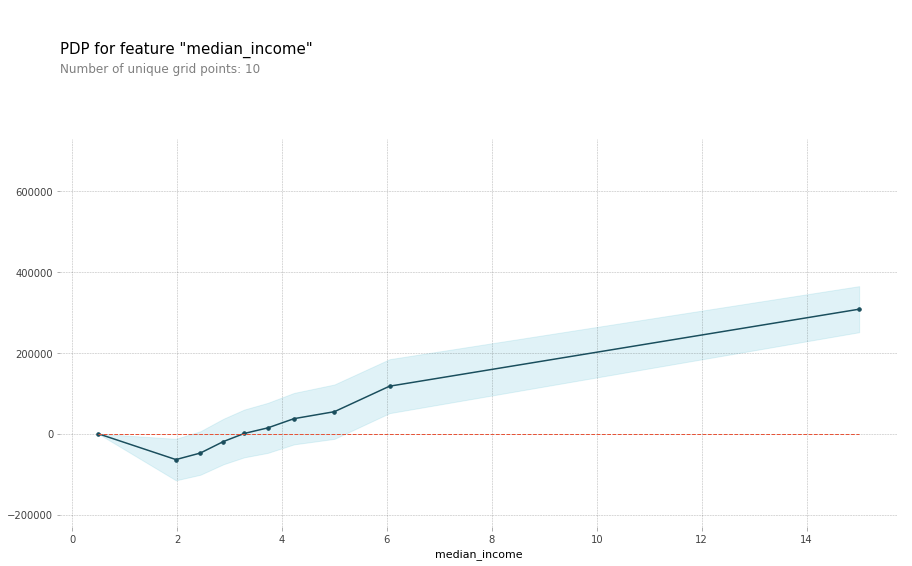

In [49]:
feature = 'median_income'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

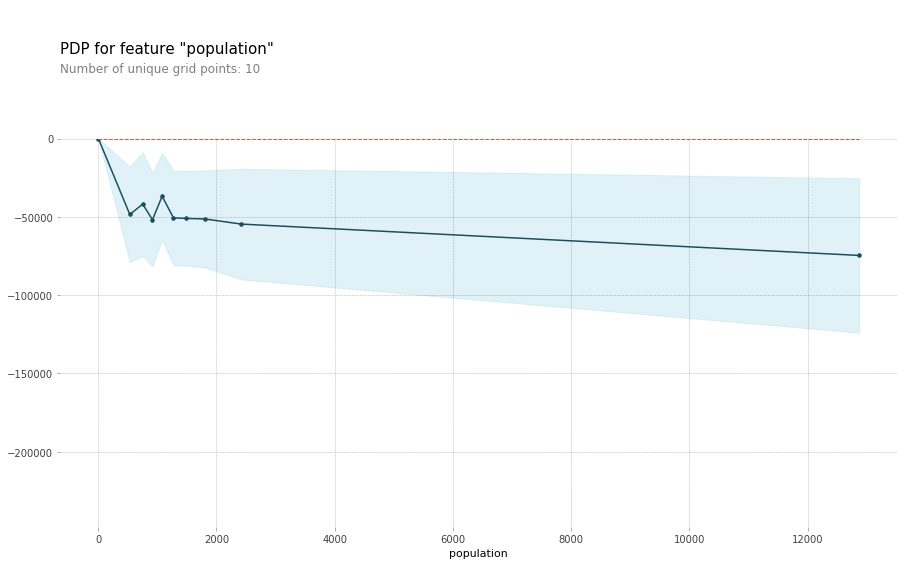

In [50]:
feature = 'population'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);